In [1]:
import numpy as np
import pandas as pd
import pandas_datareader as web
import datetime

# import a file that contains a summary statistics function
import edhec_risk_kit_206 as erk

import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
# Set color style
plt.style.use('seaborn-dark')
plt.style.use("tableau-colorblind10")

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Import Apple data
aapl = web.get_data_yahoo('AAPL', 
                          start=datetime.datetime(2009, 1, 1), 
                          end=datetime.datetime(2018, 12, 31))
aapl.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2008-12-31,12.534286,12.191428,12.281428,12.192857,151885300.0,10.583897
2009-01-02,13.005714,12.165714,12.268572,12.964286,186503800.0,11.253528
2009-01-05,13.740000,13.244286,13.310000,13.511429,295402100.0,11.728474
2009-01-06,13.881429,13.198571,13.707143,13.288571,322327600.0,11.535025
2009-01-07,13.214286,12.894286,13.115714,13.001429,188262200.0,11.285772


In [3]:
# 100 day moving average for the adjusted close, adding it to the DataFrame
aapl_100MA = aapl["Adj Close"].rolling(window=100).mean()
aapl["100MA"] = aapl_100MA
aapl.head()

,High,Low,Open,Close,Volume,Adj Close,100MA
Date,,,,,,,
2008-12-31,12.534286,12.191428,12.281428,12.192857,151885300.0,10.583897,NaN
2009-01-02,13.005714,12.165714,12.268572,12.964286,186503800.0,11.253528,NaN
2009-01-05,13.740000,13.244286,13.310000,13.511429,295402100.0,11.728474,NaN
2009-01-06,13.881429,13.198571,13.707143,13.288571,322327600.0,11.535025,NaN
2009-01-07,13.214286,12.894286,13.115714,13.001429,188262200.0,11.285772,NaN


In [4]:
apple = aapl[["Adj Close", "100MA"]]
apple.dropna(inplace=True)
apple.head()

,Adj Close,100MA
Date,,
2009-05-26,16.217484,12.986957
2009-05-27,16.498974,13.046108
2009-05-28,16.749466,13.101067
2009-05-29,16.841228,13.152195
2009-06-01,17.280214,13.209647


Create a list of our position in Apple for each day. If the price is higher than the MA we go long, if the price is lower, go short. Since in our case we only use daily close, we have to wait until the next day before taking a position

In [5]:
Position = []
for i in range(0,apple.shape[0]):
    if apple["Adj Close"].iloc[i] > apple["100MA"].iloc[i]:
        Position.append("Long")
    else:
        Position.append("Short")

apple["Position"] = Position
apple.head()

,Adj Close,100MA,Position
Date,,,
2009-05-26,16.217484,12.986957,Long
2009-05-27,16.498974,13.046108,Long
2009-05-28,16.749466,13.101067,Long
2009-05-29,16.841228,13.152195,Long
2009-06-01,17.280214,13.209647,Long


Compute daily returns for Apple

In [6]:
# return as percentage change from yesterday to today
apple["return"] = (apple["Adj Close"] - apple["Adj Close"].shift())/apple["Adj Close"].shift()
apple.dropna(inplace=True)
apple.head()

,Adj Close,100MA,Position,return
Date,,,,
2009-05-27,16.498974,13.046108,Long,0.017357
2009-05-28,16.749466,13.101067,Long,0.015182
2009-05-29,16.841228,13.152195,Long,0.005479
2009-06-01,17.280214,13.209647,Long,0.026066
2009-06-02,17.297573,13.269765,Long,0.001005


Add up the daily changes depending on our position. If we are long, add the change in price, if we are short, subtract the price. The starting value of our strategy or position will be the starting value of Apple.

In [7]:
# Start with initial amount equal to the value of Apple at time 1
# If the position of yesterday was long, then we add the gain from today to tomorrow
# by multiplying (1+r)
# if the position was short, we subtract the gain or loss by multyplying with (1+r).


LongShort = [0]*apple.shape[0]
LongHold = [0]*apple.shape[0]

LongShort[0] = apple["Adj Close"].iloc[0]
LongShort[1] = apple["Adj Close"].iloc[0]
LongHold[0] = apple["Adj Close"].iloc[0]    
LongHold[1] = apple["Adj Close"].iloc[0]    

    
for i in range(0, apple.shape[0]-2):
    if apple["Position"].iloc[i] == "Long":
        LongShort[i+2] = LongShort[i+1]*(1+apple["return"][i+2])
    else:
        LongShort[i+2] = LongShort[i+1]/(1+apple["return"][i+2])
        
for i in range(0, apple.shape[0]-2):
    if apple["Position"].iloc[i] == "Long":
        LongHold[i+2] = LongHold[i+1]*(1+apple["return"][i+2])
    else:
        LongHold[i+2] = LongHold[i+1]

apple["LongShort"] = LongShort
apple["LongHold"] = LongHold
apple.drop(apple.tail(1).index,inplace=True)
apple.head()

,Adj Close,100MA,Position,return,LongShort,LongHold
Date,,,,,,
2009-05-27,16.498974,13.046108,Long,0.017357,16.498974,16.498974
2009-05-28,16.749466,13.101067,Long,0.015182,16.498974,16.498974
2009-05-29,16.841228,13.152195,Long,0.005479,16.589364,16.589364
2009-06-01,17.280214,13.209647,Long,0.026066,17.021785,17.021785
2009-06-02,17.297573,13.269765,Long,0.001005,17.038884,17.038884


Plot the strategy together with the price of apple stock over the period


Our goal for the MA crossover strategy is to achieve the asset return in periods when the its value is increasing, but avoid the drawdown by either selling and holding cash, or shorting the asset when the value is decreasing.

As we can see from the graph, when the asset price changes smoothly, the moving average catch the trend a lot better than in the case where the price is more wiggly.

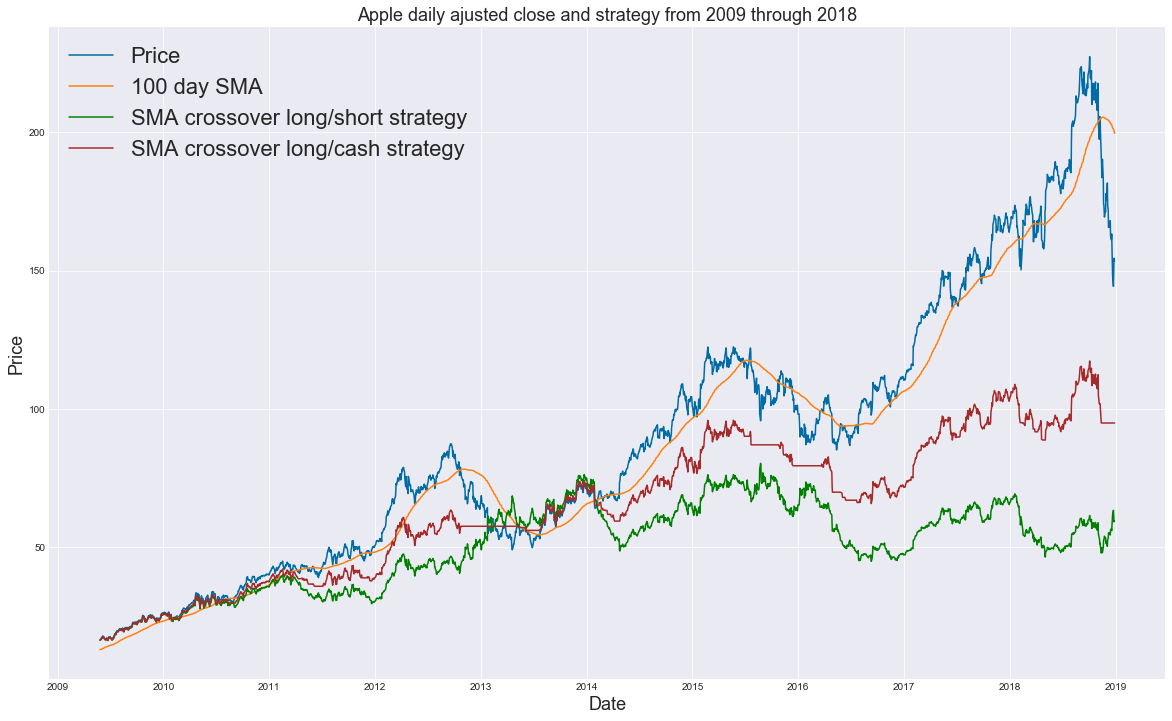

In [8]:
fig = plt.figure(figsize=(20,12))
ax1 = plt.plot(apple["Adj Close"])
ax1 = plt.plot(apple["100MA"])
ax1 = plt.plot(apple["LongShort"], color="green")
ax1 = plt.plot(apple["LongHold"], color="brown")
ax1 = plt.title("Apple daily ajusted close and strategy from 2009 through 2018", fontsize=18)
ax1 = plt.xlabel("Date", fontsize=18)
ax1 = plt.ylabel("Price", fontsize=18)
ax1 = plt.legend(["Price", "100 day SMA", "SMA crossover long/short strategy",
                  "SMA crossover long/cash strategy"],prop={"size":22}, loc="upper left")
plt.grid(True)
plt.show()

### Copy the previous code and replace the SMA with the EMA

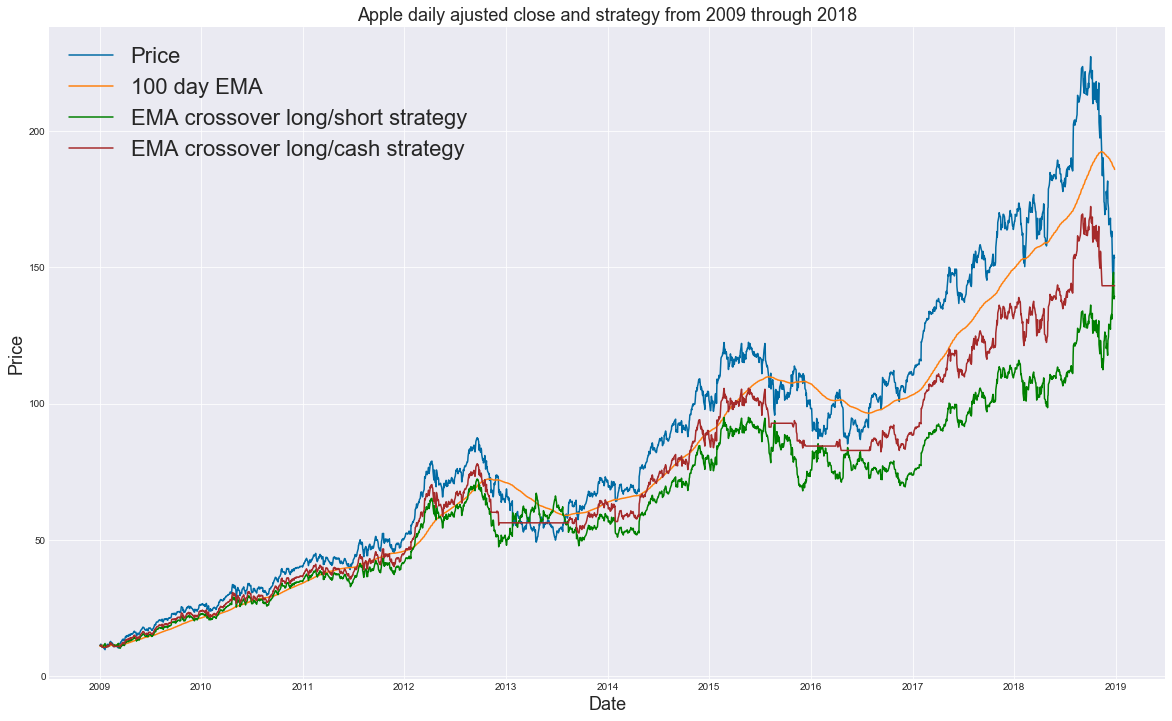

In [9]:
# Import Apple data
aapl = web.get_data_yahoo('AAPL', 
                          start=datetime.datetime(2009, 1, 1), 
                          end=datetime.datetime(2018, 12, 31))

aapl_100EMA = aapl["Adj Close"].ewm(100).mean()
aapl["100EMA"] = aapl_100EMA

apple = aapl[["Adj Close", "100EMA"]]
apple.dropna(inplace=True)

Position = []
for i in range(0,apple.shape[0]):
    if apple["Adj Close"].iloc[i] > apple["100EMA"].iloc[i]:
        Position.append("Long")
    else:
        Position.append("Short")

apple["Position"] = Position

apple["return"] = (apple["Adj Close"] - apple["Adj Close"].shift())/apple["Adj Close"].shift()
apple.dropna(inplace=True)

LongShort = [0]*apple.shape[0]
LongHold = [0]*apple.shape[0]

LongShort[0] = apple["Adj Close"].iloc[0]
LongShort[1] = apple["Adj Close"].iloc[0]
LongHold[0] = apple["Adj Close"].iloc[0]    
LongHold[1] = apple["Adj Close"].iloc[0]    

    
for i in range(0, apple.shape[0]-2):
    if apple["Position"].iloc[i] == "Long":
        LongShort[i+2] = LongShort[i+1]*(1+apple["return"][i+2])
    else:
        LongShort[i+2] = LongShort[i+1]/(1+apple["return"][i+2])
        
for i in range(0, apple.shape[0]-2):
    if apple["Position"].iloc[i] == "Long":
        LongHold[i+2] = LongHold[i+1]*(1+apple["return"][i+2])
    else:
        LongHold[i+2] = LongHold[i+1]

apple["LongShort"] = LongShort
apple["LongHold"] = LongHold
apple.drop(apple.tail(1).index,inplace=True)

fig = plt.figure(figsize=(20,12))
ax1 = plt.plot(apple["Adj Close"])
ax1 = plt.plot(apple["100EMA"])
ax1 = plt.plot(apple["LongShort"], color="green")
ax1 = plt.plot(apple["LongHold"], color="brown")
ax1 = plt.title("Apple daily ajusted close and strategy from 2009 through 2018", fontsize=18)
ax1 = plt.xlabel("Date", fontsize=18)
ax1 = plt.ylabel("Price", fontsize=18)
ax1 = plt.legend(["Price", "100 day EMA", "EMA crossover long/short strategy", "EMA crossover long/cash strategy"],prop={"size":22}, loc="upper left")
plt.grid(True)
plt.show()

### MACD

Moving average convergence divergence compares a short term moving average with a longer term. When the shorter crosses over the longer one, the

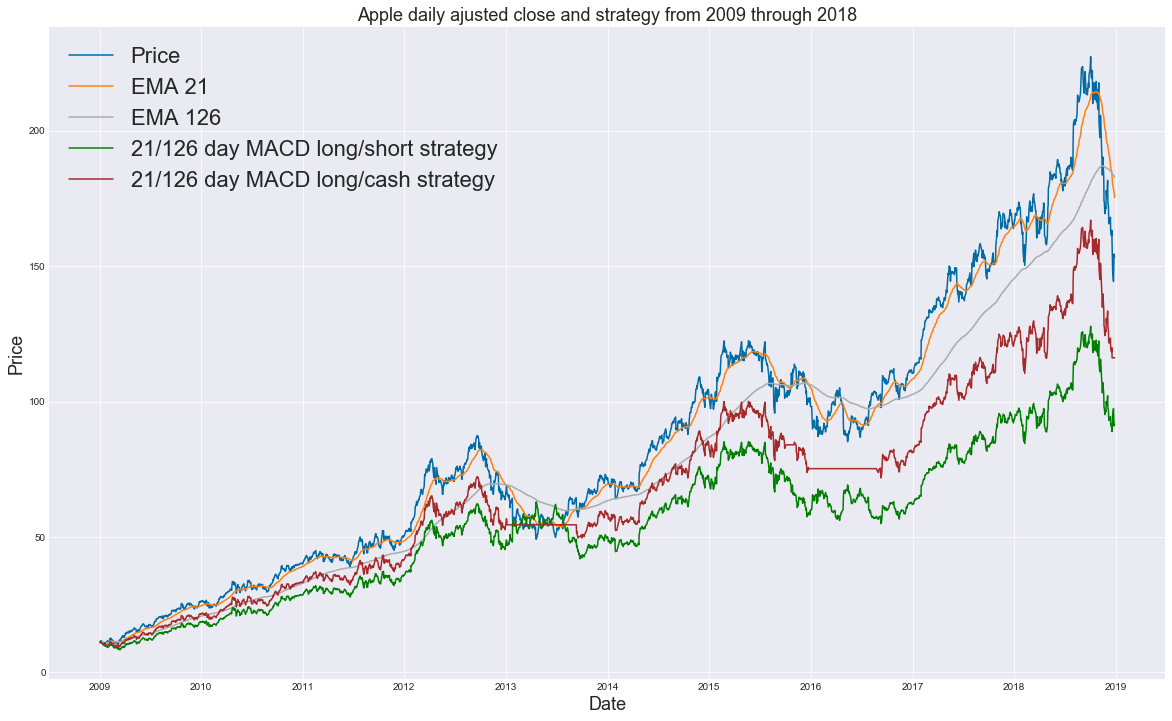

In [10]:
# Import Apple data
aapl = web.get_data_yahoo('AAPL', 
                          start=datetime.datetime(2009, 1, 1), 
                          end=datetime.datetime(2018, 12, 31))

aapl_21EMA = aapl["Adj Close"].ewm(21).mean()
aapl_126EMA = aapl["Adj Close"].ewm(126).mean()
aapl["21EMA"] = aapl_21EMA
aapl["126EMA"] = aapl_126EMA

apple = aapl[["Adj Close", "21EMA", "126EMA"]]
apple.dropna(inplace=True)

Position = []
for i in range(0,apple.shape[0]):
    if apple["21EMA"].iloc[i] > apple["126EMA"].iloc[i]:
        Position.append("Long")
    else:
        Position.append("Short")

apple["Position"] = Position

apple["return"] = (apple["Adj Close"] - apple["Adj Close"].shift())/apple["Adj Close"].shift()
apple.dropna(inplace=True)

LongShort = [0]*apple.shape[0]
LongHold = [0]*apple.shape[0]

LongShort[0] = apple["Adj Close"].iloc[0]
LongShort[1] = apple["Adj Close"].iloc[0]
LongHold[0] = apple["Adj Close"].iloc[0]    
LongHold[1] = apple["Adj Close"].iloc[0]    

    
for i in range(0, apple.shape[0]-2):
    if apple["Position"].iloc[i] == "Long":
        LongShort[i+2] = LongShort[i+1]*(1+apple["return"][i+2])
    else:
        LongShort[i+2] = LongShort[i+1]/(1+apple["return"][i+2])
        
for i in range(0, apple.shape[0]-2):
    if apple["Position"].iloc[i] == "Long":
        LongHold[i+2] = LongHold[i+1]*(1+apple["return"][i+2])
    else:
        LongHold[i+2] = LongHold[i+1]

apple["LongShort"] = LongShort
apple["LongHold"] = LongHold
apple.drop(apple.tail(1).index,inplace=True)

fig = plt.figure(figsize=(20,12))
ax1 = plt.plot(apple["Adj Close"])
ax1 = plt.plot(apple["21EMA"])
ax1 = plt.plot(apple["126EMA"])
ax1 = plt.plot(apple["LongShort"], color="green")
ax1 = plt.plot(apple["LongHold"], color="brown")
ax1 = plt.title("Apple daily ajusted close and strategy from 2009 through 2018", fontsize=18)
ax1 = plt.xlabel("Date", fontsize=18)
ax1 = plt.ylabel("Price", fontsize=18)
ax1 = plt.legend(["Price", "EMA 21", "EMA 126", "21/126 day MACD long/short strategy", "21/126 day MACD long/cash strategy"],prop={"size":22}, loc="upper left")
plt.grid(True)
plt.show()

I will create a general function where we can choose which strategy to include

In [11]:
def strategies(df, days, MA=False, EMA=False, MACD=False):
    """
    Add selected moving averages to the DataFrame
    """
    if MA==True:
    # simple moving average
        df["MA"] = df["Adj Close"].rolling(window=days).mean()
    
    if EMA==True:
    # exponential moving average
        df["EMA"] = df["Adj Close"].ewm(span=days).mean()

    if MACD==True:
        # exponential moving average
        df["EMA_21"] = df["Adj Close"].ewm(span=21).mean()
        df["EMA_126"] = df["Adj Close"].ewm(span=126).mean()
            
    return df
    

def positions(df, MA=False, EMA=False, MACD=False):
    """
    calculates the positions we should hold each day according to each strategy
    """
    df_positions = pd.DataFrame(index=df.index)
    if MA==True:
    # Add position type for each day for the MA
        MA_Position = []    
        for i in range(0,df.shape[0]):
            if df["Adj Close"].iloc[i] > df["MA"].iloc[i]:
                MA_Position.append("Long")
            else:
                MA_Position.append("Short")
        df_positions["MA_Position"] = MA_Position
    
    if EMA==True:
    # Add position type for each day for the EMA
        EMA_Position = []
        for i in range(0,df.shape[0]):
            if df["Adj Close"].iloc[i] > df["EMA"].iloc[i]:
                EMA_Position.append("Long")
            else:
                EMA_Position.append("Short")
        df_positions["EMA_Position"] = EMA_Position
        
    if MACD==True:
    # Add position type for each day for the EMA
        MACD_Position = []
        for i in range(0,df.shape[0]):
            if df["EMA_21"].iloc[i] > df["EMA_126"].iloc[i]:
                MACD_Position.append("Long")
            else:
                MACD_Position.append("Short")
        df_positions["MACD_Position"] = MACD_Position
    
    return df_positions


def price_of_strategy(df, df_positions, LongHold=False, LongShort=False, MA=False, EMA=False, MACD=False):
    """
    given a DataFrame containing one or more position vectors, 
    Create price process of the strategies, adding the daily change if we are long
    subtracting if we are short.
    """
    df_price_of_strategy = pd.DataFrame(index=df_positions.index)
    df_price_of_strategy["asset price"] = df["Adj Close"]
    # long hold will long the strategy if condition is met, but instead of shorting it will
    # simply sell and wait for another entry point. A better version of this would be to
    # buy bonds instead of holding cash.
    if LongHold == True:
        if MA == True:
            LongHold = [0]*df.shape[0]
            LongHold[0] = df["Adj Close"].iloc[0]
            LongHold[1] = df["Adj Close"].iloc[0]
            for i in range(0, df_positions.shape[0]-2):
                if df_positions["MA_Position"].iloc[i] == "Long":
                    LongHold[i+2] = LongHold[i+1]*(1+df["return"][i+2])
                else:
                    LongHold[i+2] = LongHold[i+1]
            df_price_of_strategy["LongHold MA"] = LongHold
            
        if EMA == True:
            LongHold = [0]*df.shape[0]
            LongHold[0] = df["Adj Close"].iloc[0]
            LongHold[1] = df["Adj Close"].iloc[0]
            for i in range(0, df_positions.shape[0]-2):
                if df_positions["EMA_Position"].iloc[i] == "Long":
                    LongHold[i+2] = LongHold[i+1]*(1+df["return"][i+2])
                else:
                    LongHold[i+2] = LongHold[i+1]
            df_price_of_strategy["LongHold EMA"] = LongHold
            
        if MACD == True:
            LongHold = [0]*df.shape[0]
            LongHold[0] = df["Adj Close"].iloc[0]
            LongHold[1] = df["Adj Close"].iloc[0]
            for i in range(0, df_positions.shape[0]-2):
                if df_positions["MACD_Position"].iloc[i] == "Long":
                    LongHold[i+2] = LongHold[i+1]*(1+df["return"][i+2])
                else:
                    LongHold[i+2] = LongHold[i+1]
            df_price_of_strategy["LongHold MACD"] = LongHold
    
    
    if LongShort == True:
        if MA == True:
            LongShort = [0]*df.shape[0]
            LongShort[0] = df["Adj Close"].iloc[0]
            LongShort[1] = df["Adj Close"].iloc[0]
            for i in range(0, df.shape[0]-2):
                if df_positions["MA_Position"].iloc[i] == "Long":
                    LongShort[i+2] = LongShort[i+1]*(1+df["return"][i+2])
                else:
                    LongShort[i+2] = LongShort[i+1]/(1+df["return"][i+2])
            df_price_of_strategy["LongShort MA"] = LongShort
                
        if EMA == True:
            LongShort = [0]*df.shape[0]
            LongShort[0] = df["Adj Close"].iloc[0]
            LongShort[1] = df["Adj Close"].iloc[0]
            for i in range(0, df.shape[0]-2):
                if df_positions["EMA_Position"].iloc[i] == "Long":
                    LongShort[i+2] = LongShort[i+1]*(1+df["return"][i+2])
                else:
                    LongShort[i+2] = LongShort[i+1]/(1+df["return"][i+2])
            df_price_of_strategy["LongShort EMA"] = LongShort
            
        if MACD == True:
            LongShort = [0]*df.shape[0]
            LongShort[0] = df["Adj Close"].iloc[0]
            LongShort[1] = df["Adj Close"].iloc[0]
            for i in range(0, df.shape[0]-2):
                if df_positions["MACD_Position"].iloc[i] == "Long":
                    LongShort[i+2] = LongShort[i+1]*(1+df["return"][i+2])
                else:
                    LongShort[i+2] = LongShort[i+1]/(1+df["return"][i+2])
            df_price_of_strategy["LongShort MACD"] = LongShort
    
    return df_price_of_strategy


def strategy_returns(df, df_price_of_strategy):
    """
    input the price series of a strategy and output the return series
    """
    df_return_of_strategy = pd.DataFrame(index=df_price_of_strategy.index)
    cols = df_price_of_strategy.columns
    
    for priceSeries in cols:
        df_return_of_strategy[priceSeries] = (df_price_of_strategy[priceSeries]
                    - df_price_of_strategy[priceSeries].shift())/(df_price_of_strategy[priceSeries].shift())
    
    return df_return_of_strategy

In [12]:
def strategy(ticker, start, end, days, MA=False, EMA=False, MACD=False, LongHold=False, LongShort=False):
    """
    calculates the return on a moving average strategy of your choice
    """
    # load the data
    df = web.get_data_yahoo(f'{ticker}', 
                              start=start, 
                              end=end)
    # Daily return in the asset value
    df["return"] = (df["Adj Close"] - df["Adj Close"].shift())/df["Adj Close"].shift()
    
    # only keep the adjusted close and daily return
    df = df[["Adj Close", "return"]]
    
    # choose which moving averages we want
    df = strategies(df=df, days=100, MA=MA, EMA=EMA, MACD=MACD)
    
    # drop na's from the MA calculations
    df.dropna(inplace=True)
    
    # DataFrame of the positions we wish to hold
    df_positions = positions(df, MA=MA, EMA=EMA, MACD=MACD)

    #
    df_price_of_strategy = price_of_strategy(df, df_positions, LongHold=LongHold,
                                             LongShort=LongHold, MA=MA, EMA=EMA, MACD=MACD)
    df_price_of_strategy = df_price_of_strategy.drop(df_price_of_strategy.tail(2).index)

    # view summary statistics of the return series of the three strategies
    df_return_of_strategy = strategy_returns(df, df_price_of_strategy)
    df_return_of_strategy.dropna(inplace=True)
    table = erk.summary_stats(df_return_of_strategy, ppp=252)
    return df, table, df_return_of_strategy, df_positions, df_price_of_strategy

def plot_strategy(ticker, start, end, df):
    """
    Plot the performance of the strategy vs the performance of the asset
    """
    fig = plt.figure(figsize=(20,10))
    ax1 = plt.plot(df)
    ax1 = plt.title("Comparing simple investment strategies for " +
                        ticker + " between " + start + " and " + end, fontsize=22)
    ax1 = plt.xlabel("Date", fontsize=18)
    ax1 = plt.ylabel("Price", fontsize=18)
    ax1 = plt.legend(list(df_price_of_strategy.columns),prop={"size":18}, loc="upper left")
    
    for legobj in ax1.legendHandles:
        legobj.set_linewidth(5.0)

    plt.grid(True)
    plt.show()

### Performance in Bull Markets

* Apple from 2009 through 2018
* S&P 500 from 2009 through 2018

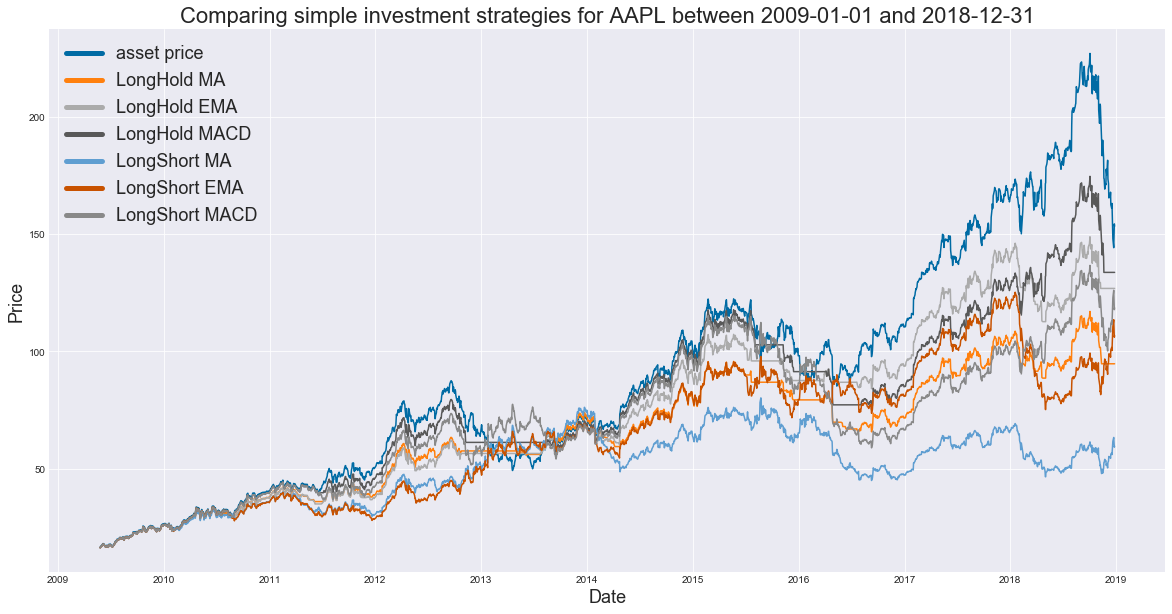

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
asset price,0.264296,0.256611,-0.089104,6.924310,0.024649,0.035936,0.886544,-0.437972
LongHold MA,0.202217,0.206870,0.137748,8.075195,0.018765,0.030520,0.808331,-0.314047
LongHold EMA,0.239474,0.207737,0.236796,8.097227,0.018342,0.030019,0.979104,-0.229006
LongHold MACD,0.246295,0.220096,0.150238,7.280062,0.020036,0.031933,0.954214,-0.361904
LongShort MA,0.145240,0.257518,0.293193,7.653271,0.023107,0.036000,0.434507,-0.440348
LongShort EMA,0.217324,0.257611,0.382875,7.688941,0.022430,0.035435,0.706050,-0.400050
LongShort MACD,0.230758,0.257473,0.328476,7.687635,0.022637,0.035711,0.757091,-0.489982


In [14]:
start = datetime.date(2009, 1, 1)
end = datetime.date(2018, 12, 31)
ticker = "AAPL"
days = 100

df, table, df_return_of_strategy, df_positions, df_price_of_strategy = strategy(
            ticker, start, end, days=days, MA=True, EMA=True, MACD=True, LongHold=True, LongShort=True)

plot_strategy(ticker=ticker, start=str(start), end=str(end), df=df_price_of_strategy)
table

In [15]:
df_price_of_strategy.head()

,asset price,LongHold MA,LongHold EMA,LongHold MACD,LongShort MA,LongShort EMA,LongShort MACD
Date,,,,,,,
2009-05-26,16.217484,16.217484,16.217484,16.217484,16.217484,16.217484,16.217484
2009-05-27,16.498974,16.217484,16.217484,16.217484,16.217484,16.217484,16.217484
2009-05-28,16.749466,16.463702,16.463702,16.463702,16.463702,16.463702,16.463702
2009-05-29,16.841228,16.553899,16.553899,16.553899,16.553899,16.553899,16.553899
2009-06-01,17.280214,16.985395,16.985395,16.985395,16.985395,16.985395,16.985395


In [16]:
df.head()

,Adj Close,return,MA,EMA,EMA_21,EMA_126
Date,,,,,,
2009-05-26,16.217484,0.067592,12.986957,13.989999,15.490652,13.795388
2009-05-27,16.498974,0.017357,13.046108,14.047280,15.582323,13.848692
2009-05-28,16.749466,0.015182,13.101067,14.108785,15.688434,13.905657
2009-05-29,16.841228,0.005479,13.152195,14.170796,15.793239,13.963082
2009-06-01,17.280214,0.026066,13.209647,14.241158,15.928425,14.027725


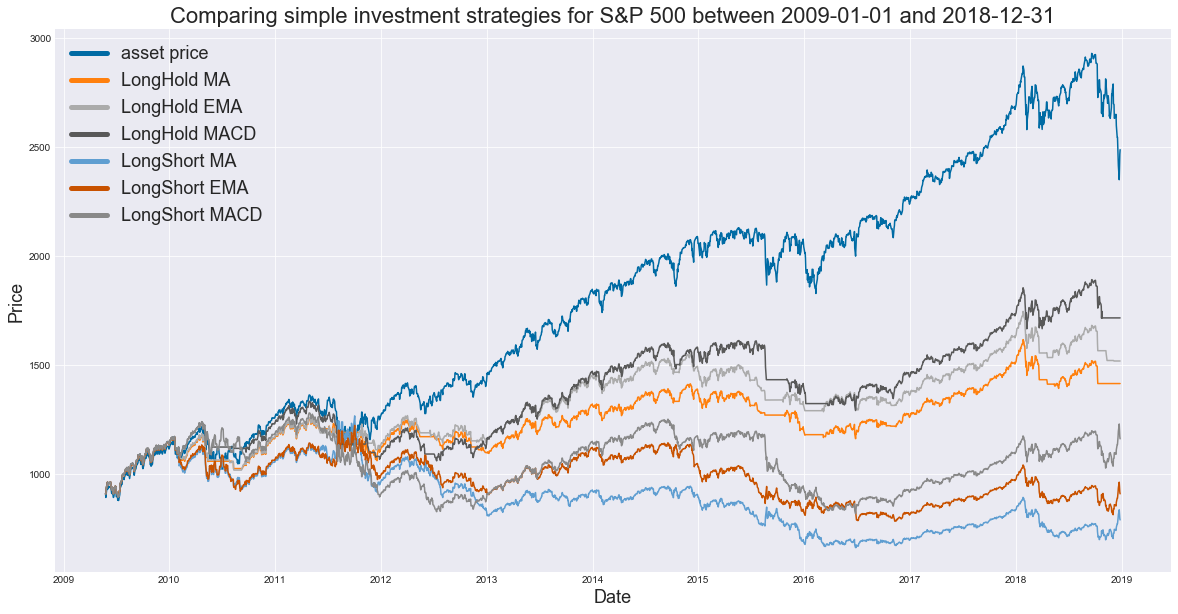

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
asset price,0.110654,0.151849,-0.382798,7.053757,0.015500,0.023641,0.515728,-0.197782
LongHold MA,0.047159,0.108919,-0.725693,7.237966,0.011837,0.018239,0.152965,-0.177339
LongHold EMA,0.054895,0.110964,-0.670992,7.006616,0.011968,0.018379,0.217839,-0.170274
LongHold MACD,0.068454,0.120481,-0.608015,7.216425,0.012803,0.019578,0.309901,-0.204887
LongShort MA,-0.014677,0.152010,-0.080658,7.235397,0.015160,0.023507,-0.285387,-0.476885
LongShort EMA,-0.000064,0.152025,-0.076673,7.238548,0.015092,0.023527,-0.192031,-0.358789
LongShort MACD,0.025805,0.151956,-0.181320,7.205203,0.015270,0.023652,-0.026817,-0.361160


In [17]:
start = datetime.date(2009, 1, 1)
end = datetime.date(2018, 12, 31)
ticker = "^GSPC"
days = 100

df, table, df_return_of_strategy, df_positions, df_price_of_strategy = strategy(
            ticker, start, end, days=days, MA=True, EMA=True, MACD=True, LongHold=True, LongShort=True)

plot_strategy(ticker="S&P 500", start=str(start), end=str(end), df=df_price_of_strategy)
table

### Bull to Bear market

* Tech bubble, NASDAQ 1998 through 2001
* Global financial crisis, S&P 500 from 2006 through 2010
* The lost decade, Nikkei 225 in the 90's

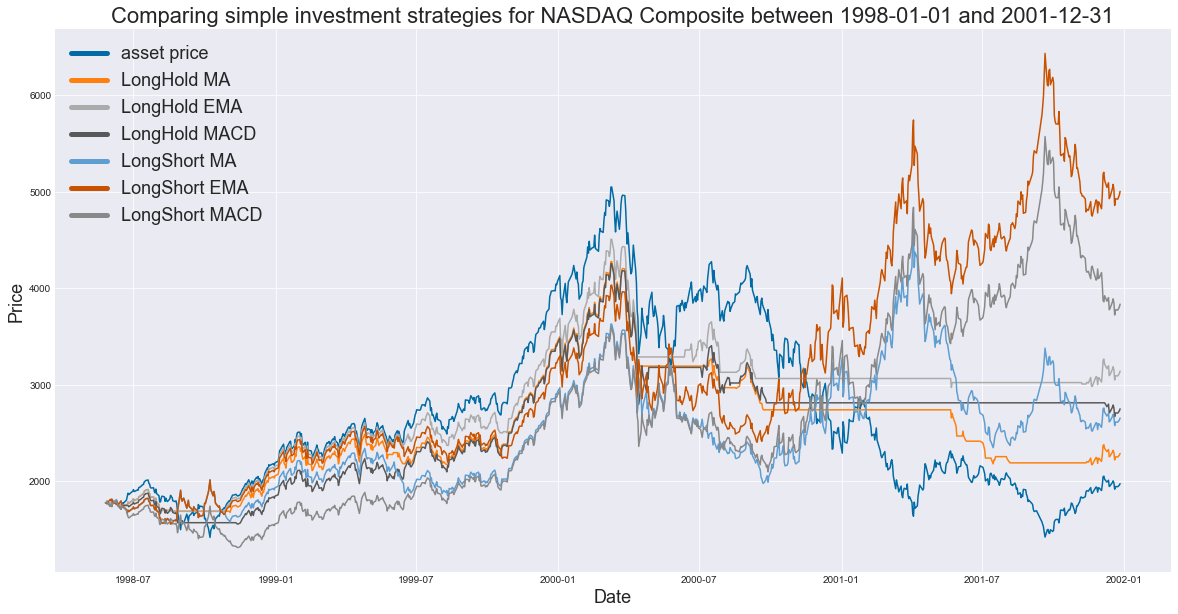

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
asset price,0.029951,0.395071,0.187587,5.057740,0.038112,0.052977,-0.000144,-0.718103
LongHold MA,0.073020,0.219590,-0.641329,6.558332,0.023785,0.036091,0.190212,-0.492237
LongHold EMA,0.172193,0.219201,-0.657186,6.673696,0.023417,0.035976,0.629859,-0.340726
LongHold MACD,0.129496,0.240716,-0.498880,8.079402,0.024854,0.038141,0.401326,-0.372233
LongShort MA,0.118417,0.393200,-0.215208,4.663444,0.040629,0.055906,0.218318,-0.488478
LongShort EMA,0.334710,0.392810,-0.278921,4.706565,0.040298,0.056011,0.753195,-0.403617
LongShort MACD,0.239246,0.392863,-0.284001,4.611271,0.040680,0.055934,0.517144,-0.415515


In [18]:
# let's look at the tech bubble
start = datetime.date(1998, 1, 1)
end = datetime.date(2001, 12, 31)
ticker = "^IXIC"
days = 100

df, table, df_return_of_strategy, df_positions, df_price_of_strategy = strategy(
            ticker, start, end, days=days, MA=True, EMA=True, MACD=True, LongHold=True, LongShort=True)

plot_strategy(ticker="NASDAQ Composite", start=str(start), end=str(end), df=df_price_of_strategy)
table

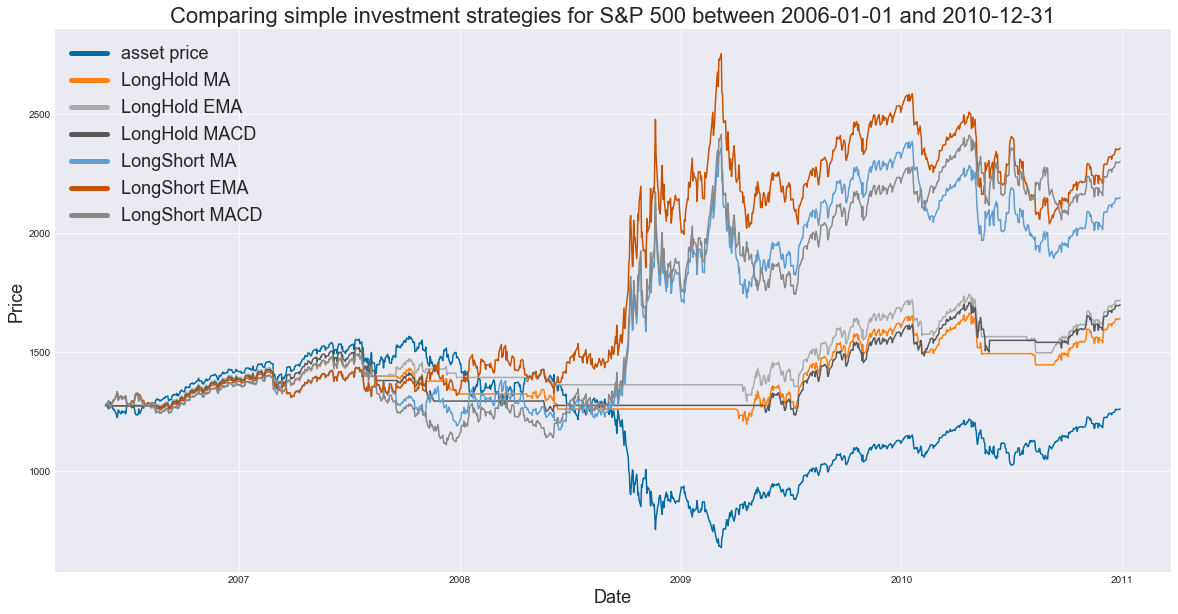

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
asset price,-0.002251,0.258724,0.019200,11.137406,0.023908,0.040505,-0.121051,-0.567754
LongHold MA,0.056854,0.113947,-0.672867,9.173701,0.011974,0.020272,0.228823,-0.196214
LongHold EMA,0.067489,0.111645,-0.612417,9.499060,0.011532,0.019604,0.326040,-0.141356
LongHold MACD,0.064741,0.113418,-0.429088,9.683943,0.011355,0.019665,0.297414,-0.187096
LongShort MA,0.120850,0.259263,0.269405,10.892816,0.022394,0.037900,0.340237,-0.267450
LongShort EMA,0.143523,0.259255,0.274009,10.888180,0.022293,0.037716,0.425164,-0.266835
LongShort MACD,0.137643,0.259320,0.302184,10.882868,0.022185,0.037535,0.403038,-0.278819


In [19]:
start = datetime.date(2006, 1, 1)
end = datetime.date(2010, 12, 31)
ticker = "^GSPC"
days = 100

df, table, df_return_of_strategy, df_positions, df_price_of_strategy = strategy(
            ticker, start, end, days=days, MA=True, EMA=True, MACD=True, LongHold=True, LongShort=True)

plot_strategy(ticker="S&P 500", start=str(start), end=str(end), df=df_price_of_strategy)
table

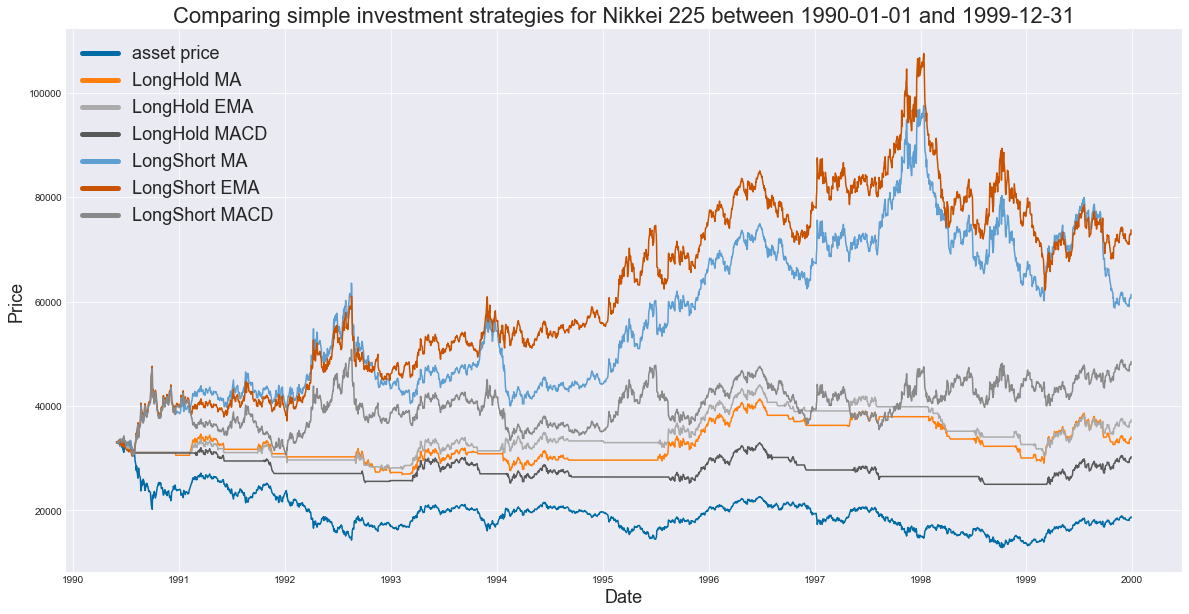

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
asset price,-0.058700,0.241049,0.520944,7.468137,0.021402,0.033057,-0.357309,-0.611961
LongHold MA,0.003011,0.127526,0.251832,9.210550,0.011576,0.020082,-0.205500,-0.297711
LongHold EMA,0.012877,0.126306,0.613309,12.616270,0.010015,0.019549,-0.131639,-0.307073
LongHold MACD,-0.009477,0.110208,0.267031,9.884321,0.009930,0.017809,-0.347819,-0.245867
LongShort MA,0.067941,0.239821,-0.216908,6.421903,0.024344,0.033891,0.153602,-0.397499
LongShort EMA,0.089054,0.239965,-0.133559,6.473104,0.023915,0.033496,0.238940,-0.422108
LongShort MACD,0.041513,0.239825,-0.213851,6.413548,0.024433,0.034050,0.046600,-0.352162


In [20]:
# The lost decade. Nikkei 225 in the 90's
start = datetime.date(1990, 1, 1)
end = datetime.date(1999, 12, 31)
ticker = "^N225"
days = 100

df, table, df_return_of_strategy, df_positions, df_price_of_strategy = strategy(
            ticker, start, end, days=days, MA=True, EMA=True, MACD=True, LongHold=True, LongShort=True)

plot_strategy(ticker="Nikkei 225", start=str(start), end=str(end), df=df_price_of_strategy)
table

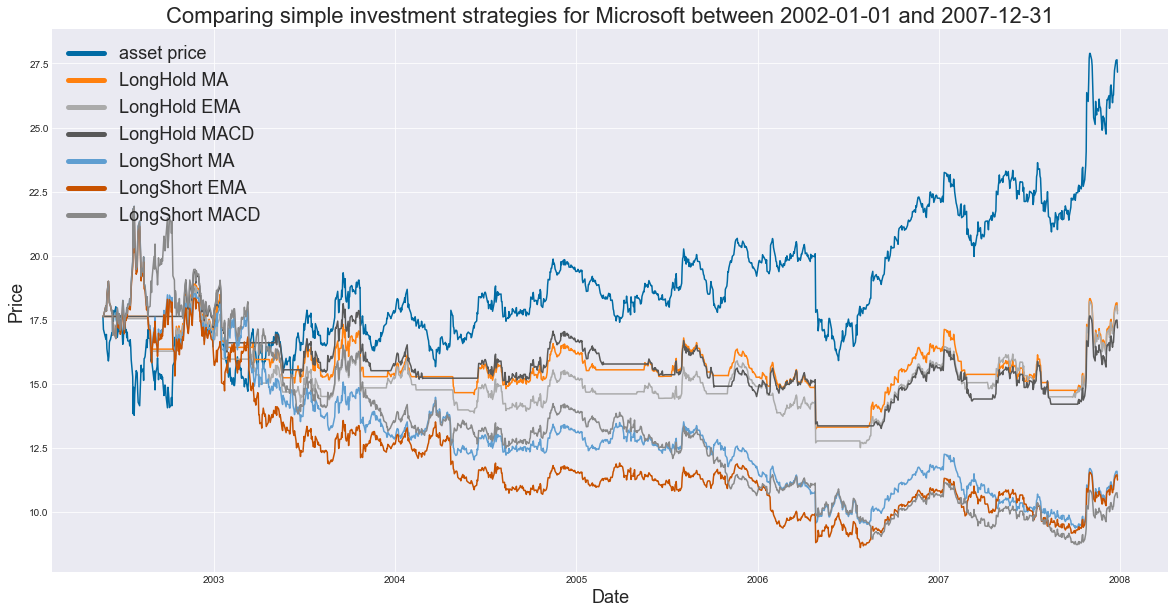

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
asset price,0.080320,0.249762,-0.010616,9.244651,0.023505,0.034917,0.195611,-0.235042
LongHold MA,0.002158,0.169854,-0.520554,22.394804,0.014869,0.026248,-0.159173,-0.299221
LongHold EMA,0.001050,0.168488,-0.624586,22.744371,0.014969,0.026335,-0.166846,-0.334483
LongHold MACD,-0.004563,0.169502,-0.584813,22.214565,0.015085,0.026149,-0.198005,-0.315263
LongShort MA,-0.075137,0.249045,-0.143910,9.554858,0.024543,0.037902,-0.409923,-0.572260
LongShort EMA,-0.077180,0.248938,-0.196681,9.554054,0.024772,0.038365,-0.418069,-0.603170
LongShort MACD,-0.087501,0.248956,-0.173853,9.551426,0.024720,0.038287,-0.458292,-0.601507


In [21]:
# Let's look at a stock that was very stable through for a given time period
# to see how the MA strategy might perform in periods of stagnation
# this kind of strategy works best when the markets have long up trends and long downtrends
start = datetime.date(2002, 1, 1)
end = datetime.date(2007, 12, 31)
ticker = "MSFT"
days = 100

df, table, df_return_of_strategy, df_positions, df_price_of_strategy = strategy(
            ticker, start, end, days=days, MA=True, EMA=True, MACD=True, LongHold=True, LongShort=True)

plot_strategy(ticker="Microsoft", start=str(start), end=str(end), df=df_price_of_strategy)
table